<a href="https://colab.research.google.com/github/thzizsreev/sreev2/blob/main/re_in_learn_test3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Imports
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow import keras
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.optimizers import Adam
import random

#Create Gym
from gym import wrappers
envCartPole = gym.make('CartPole-v1')
envCartPole.seed(50) #Set the seed to keep the environment consistent across runs

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


[50]

In [9]:
#Global Variables
EPISODES = 500
TRAIN_END = 0

In [3]:
#Hyper Parameters
def discount_rate(): #Gamma
    return 0.95

def learning_rate(): #Alpha
    return 0.001

def batch_size(): #Size of the batch used in the experience replay
    return 24

In [4]:
class DeepQNetwork():
    def __init__(self, states, actions, alpha, gamma, epsilon,epsilon_min, epsilon_decay):
        self.nS = states
        self.nA = actions
        self.memory = deque([], maxlen=2500)
        self.alpha = alpha
        self.gamma = gamma
        #Explore/Exploit
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = self.build_model()
        self.loss = []

    def build_model(self):
        model = keras.Sequential() #linear stack of layers https://keras.io/models/sequential/
        model.add(keras.layers.Dense(24, input_dim=self.nS, activation='relu')) #[Input] -> Layer 1
        #   Dense: Densely connected layer https://keras.io/layers/core/
        #   24: Number of neurons
        #   input_dim: Number of input variables
        #   activation: Rectified Linear Unit (relu) ranges >= 0
        model.add(keras.layers.Dense(24, activation='relu')) #Layer 2 -> 3
        model.add(keras.layers.Dense(self.nA, activation='linear')) #Layer 3 -> [output]
        #   Size has to match the output (different actions)
        #   Linear activation on the last layer
        model.compile(loss='mean_squared_error', #Loss function: Mean Squared Error
                      optimizer=keras.optimizers.Adam(learning_rate=self.alpha)) #Optimaizer: Adam (Feel free to check other options)
        return model

    def action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.nA) #Explore
        action_vals = self.model.predict(state) #Exploit: Use the NN to predict the correct action from this state
        return np.argmax(action_vals[0])

    def test_action(self, state): #Exploit
        action_vals = self.model.predict(state)
        return np.argmax(action_vals[0])

    def store(self, state, action, reward, nstate, done):
        #Store the experience in memory
        self.memory.append( (state, action, reward, nstate, done) )

    def experience_replay(self, batch_size):
        #Execute the experience replay
        minibatch = random.sample( self.memory, batch_size ) #Randomly sample from memory

        #Convert to numpy for speed by vectorization
        x = []
        y = []
        #edited
        # np_array = np.array(minibatch)
        # st = np.zeros((0,self.nS)) #States
        # nst = np.zeros( (0,self.nS) )#Next States
        # for i in range(len(np_array)): #Creating the state and next state np arrays
        #     st = np.append( st, np_array[i,0], axis=0)
        #     nst = np.append( nst, np_array[i,3], axis=0)
        st = np.array([sample[0][0] for sample in minibatch])
        nst = np.array([sample[3][0] for sample in minibatch])
        #edited
        st_predict = self.model.predict(st) #Here is the speedup! I can predict on the ENTIRE batch
        nst_predict = self.model.predict(nst)
        index = 0
        for state, action, reward, nstate, done in minibatch:
            x.append(state)
            #Predict from state
            nst_action_predict_model = nst_predict[index]
            if done == True: #Terminal: Just assign reward much like {* (not done) - QB[state][action]}
                target = reward
            else:   #Non terminal
                target = reward + self.gamma * np.amax(nst_action_predict_model)
            target_f = st_predict[index]
            target_f[action] = target
            y.append(target_f)
            index += 1
        #Reshape for Keras Fit

        x_reshape = np.array(x).reshape(batch_size,self.nS)
        y_reshape = np.array(y)
        epoch_count = 1 #Epochs is the number or iterations
        hist = self.model.fit(x_reshape, y_reshape, epochs=epoch_count, verbose=0)
        #Graph Losses
        for i in range(epoch_count):
            self.loss.append( hist.history['loss'][i] )
        #Decay Epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [5]:
#Create the agent
nS = envCartPole.observation_space.shape[0] #This is only 4
nA = envCartPole.action_space.n #Actions
dqn = DeepQNetwork(nS, nA, learning_rate(), discount_rate(), 1, 0.001, 0.995 )

batch_size = batch_size()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
#Training
rewards = [] #Store rewards for graphing
epsilons = [] # Store the Explore/Exploit
TEST_Episodes = 0
for e in range(EPISODES):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS]) # Resize to store in memory to pass to .predict
    tot_rewards = 0
    for time in range(210): #200 is when you "solve" the game. This can continue forever as far as I know
        action = dqn.action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape(nstate, [1, nS])
        tot_rewards += reward
        dqn.store(state, action, reward, nstate, done) # Resize to store in memory to pass to .predict
        state = nstate
        #done: CartPole fell.
        #time == 209: CartPole stayed upright
        if done or time == 209:
            rewards.append(tot_rewards)
            epsilons.append(dqn.epsilon)
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e, EPISODES, tot_rewards, dqn.epsilon))
            break
        #Experience Replay
        if len(dqn.memory) > batch_size:
            dqn.experience_replay(batch_size)
    #If our current NN passes we are done
    #I am going to use the last 5 runs
    if len(rewards) > 5 and np.average(rewards[-5:]) > 195:
        #Set the rest of the EPISODES for testing
        TEST_Episodes = EPISODES - e
        TRAIN_END = e
        break

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode: 0/10, score: 12.0, e: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
episode: 1/10, score: 17.0, e: 0.9801495006250001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1

In [7]:
#Test the agent that was trained
#   In this section we ALWAYS use exploit don't train any more
for e_test in range(TEST_Episodes):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS])
    tot_rewards = 0
    for t_test in range(210):
        action = dqn.test_action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape( nstate, [1, nS])
        tot_rewards += reward
        #DON'T STORE ANYTHING DURING TESTING
        state = nstate
        #done: CartPole fell.
        #t_test == 209: CartPole stayed upright
        if done or t_test == 209:
            rewards.append(tot_rewards)
            epsilons.append(0) #We are doing full exploit
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e_test, TEST_Episodes, tot_rewards, 0))
            break;

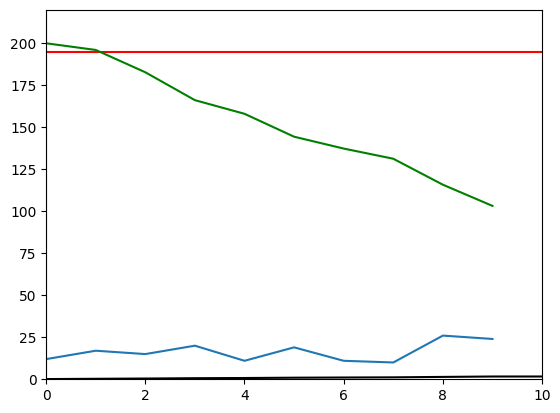

In [8]:
rolling_average = np.convolve(rewards, np.ones(100)/100)

plt.plot(rewards)
plt.plot(rolling_average, color='black')
plt.axhline(y=195, color='r', linestyle='-') #Solved Line
#Scale Epsilon (0.001 - 1.0) to match reward (0 - 200) range
eps_graph = [200*x for x in epsilons]
plt.plot(eps_graph, color='g', linestyle='-')
#Plot the line where TESTING begins
plt.axvline(x=TRAIN_END, color='y', linestyle='-')
plt.xlim( (0,EPISODES) )
plt.ylim( (0,220) )
plt.show()


envCartPole.close()